In [1]:
import os

# 수학 관련 라이브러리
import numpy as np
import math

import sys

# pytorch 관련 라이브러리
import torch
import torch.nn as nn 
import torch.nn.functional as F 

# visualization 라이브러리
import matplotlib.pyplot as plt

# sample input

In [3]:
sample_input = torch.tensor([[    1,    57,  3518,   155,     6,   943, 10716, 20433,     0,     6,
         12181,   362,     4,   588,   245,   243,   230,   241,   231,   240,
           233,   238,   239,   232,     4,  1761,    20,     2,  5063,  1007,
          2085,  2907,     4, 19454,   658,  5499,  8778,  1132,  4189,   283,
             4,     4,    20,     2,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0]])

sample_mask1 = torch.tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])


sample_mask2 = torch.tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])



sample_label = torch.tensor([0])

sample = [sample_input,sample_mask2,sample_mask1,sample_label]

sample_config = {
    "dim": 768,
    "dim_ff": 3072,
    "n_layers": 12,
    "p_drop_attn": 0.1,
    "n_heads": 12,
    "p_drop_hidden": 0.1,
    "max_len": 512,
    "n_segments": 2,
    "vocab_size": 30522
} # BERT-base

class AttributeDict(dict):
    def __getattr__(self, name):
        return self[name]
model_config = AttributeDict(sample_config)

In [4]:
sample_input.size()

torch.Size([1, 128])

In [5]:
model_config

{'dim': 768,
 'dim_ff': 3072,
 'max_len': 512,
 'n_heads': 12,
 'n_layers': 12,
 'n_segments': 2,
 'p_drop_attn': 0.1,
 'p_drop_hidden': 0.1,
 'vocab_size': 30522}

# Activation function

In [6]:
def gelu(x): # ReLU보다 안정성이 높은 함수
    return x * 0.5 * (1.0 + torch.erf(x / math.sqrt(2.0)))

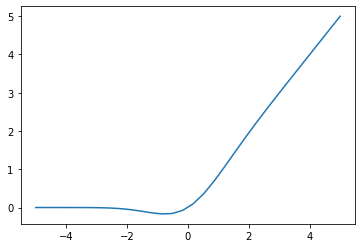

In [7]:
x = torch.linspace(-5,5,30)
plt.plot(x,gelu(x))
plt.show()

# Layer normalization

In [8]:
class LayerNorm(nn.Module):
    def __init__(self, cfg, variance_epsilon=1e-12):
        super().__init__()

        self.gamma = nn.Parameter(torch.ones(cfg.dim)) # vector dimension
        self.beta  = nn.Parameter(torch.zeros(cfg.dim)) # vector dimension
        self.variance_epsilon = variance_epsilon

    def forward(self, x):
        # x: [batch dimension(B), sequence length(S), vector dimention(F)]

        # get mean, variance
        u = x.mean(-1, keepdim=True) # 각 단어별 mean: [B, S, 1]
        s = (x - u).pow(2).mean(-1, keepdim=True) # 각 단어별 variance: [B, S, 1]
        
        # normalize
        x = (x - u) / torch.sqrt(s + self.variance_epsilon) # (x - mean)/std 
        
        return self.gamma * x + self.beta # gamma, beta를 이용해 mean, std 조정

# Embedding

In [9]:
class Embeddings(nn.Module):
    "The embedding module from word, position and token_type embeddings."
    def __init__(self, cfg):
        super().__init__()
        self.tok_embed = nn.Embedding(cfg.vocab_size, cfg.dim) # token embedding (word embedding)
        self.pos_embed = nn.Embedding(cfg.max_len, cfg.dim) # position embedding

        self.seg_embed = nn.Embedding(cfg.n_segments, cfg.dim) # segment(token type) embedding (BERT)
        # 첫문장, 두번째 문장 

        # 눈이 와서 눈이 아프다. 눈이 건조한 것 같다.
        # 나는 지금 눈이 와서    눈이 아프다. 눈이 건조한 것 같다. 
        # positional encoding

        self.norm = LayerNorm(cfg)
        self.drop = nn.Dropout(cfg.p_drop_hidden)

    def forward(self, x, seg):
        # x: [B, S] token들 
        # seg: segment_ids 첫문장, 두번째문장 구분 

        seq_len = x.size(1)
        pos = torch.arange(seq_len, dtype=torch.long, device=x.device) # 0,1,2,3,4,5, ..., seq_len-1
        pos = pos.unsqueeze(0).expand_as(x) # (S,) -> (B, S)

        # 1. positional encoding -> learnable parameter
        # 2. segment embedding
        e = self.tok_embed(x) + self.pos_embed(pos) + self.seg_embed(seg)
        return self.drop(self.norm(e))

In [10]:
model = Embeddings(model_config)

In [11]:
out = model(*sample[0:2])
out.size()


torch.Size([1, 128, 768])

In [12]:
sample[0]

tensor([[    1,    57,  3518,   155,     6,   943, 10716, 20433,     0,     6,
         12181,   362,     4,   588,   245,   243,   230,   241,   231,   240,
           233,   238,   239,   232,     4,  1761,    20,     2,  5063,  1007,
          2085,  2907,     4, 19454,   658,  5499,  8778,  1132,  4189,   283,
             4,     4,    20,     2,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,  

In [14]:
out[0,-5:] 

# Q: 뒤의 5개는 모두 pad 토큰인데 embedding 값이 다릅니다. 그 이유가 뭘까요?
# A: positional embedding 때문

tensor([[-0.2491,  1.9240,  0.2240,  ..., -0.7638, -0.2527, -2.3103],
        [ 0.0000,  2.9395,  1.0003,  ...,  0.9603,  0.8509, -0.4717],
        [ 0.6113,  1.3650,  2.4317,  ...,  0.2748,  0.1769, -1.7666],
        [ 0.4146,  1.2264,  0.0000,  ...,  0.2831, -0.1501, -1.4690],
        [-1.1226,  2.1211, -0.1087,  ..., -0.2070, -0.7612, -0.5980]],
       grad_fn=<SliceBackward0>)

#  Transformer encoder

In [15]:
class Attention(nn.Module):
    #Scaled Dot Product Attention
    
    def forward(self, query, key, value, mask=None, dropout=None):

        # query(Q), key.transpose(K^T)

        # Q: [B, S, F]
        # K: [B, S, F]
        # value(V): [B, S, F]

        # Q: [B, S, F], K^T: [B, F, S]
        # Q o K^T: [B, S, S]]
        scores = torch.matmul(query, key.transpose(-2, -1)) \
                 / math.sqrt(query.size(-1)) # scale

        if mask is not None: # transfomer에서 쓰이는 코드. 여기서는 사용하지 않음 
            scores = scores.masked_fill(mask == 0, -1e9)

        p_attn = F.softmax(scores, dim=-1) 
        # 각 query마다 모든 key에 대해 softmax. 즉, key 개수만큼 결과가 나오게 됨 (sum to one)

        if dropout is not None:
            p_attn = dropout(p_attn)

        # p_attn: [B, S, S], V: [B, S, F]
        # torch.matmul(p_attn, value): [B, S, F]
        return torch.matmul(p_attn, value), p_attn

In [16]:
class MultiHeadedSelfAttention(nn.Module):
    """ Multi-Headed Dot Product Attention """
    def __init__(self, cfg):
        super().__init__()

        # Q, K, V projection layer
        self.proj_q = nn.Linear(cfg.dim, cfg.dim)
        self.proj_k = nn.Linear(cfg.dim, cfg.dim)
        self.proj_v = nn.Linear(cfg.dim, cfg.dim)

        self.drop = nn.Dropout(cfg.p_drop_attn)
        self.scores = None # for visualization
        self.n_heads = cfg.n_heads

    def forward(self, x, mask):
        """
        x, q(query), k(key), v(value) : (B(batch_size), S(seq_len), D(dim))
        mask : (B(batch_size) x S(seq_len))
        * split D(dim) into (H(n_heads), W(width of head)) ; D = H * W
        """
        # 위에서는 vector dimention을 F라 했지만 여기부터는 D로 함... (헷갈려..)

        B,S,D = x.shape # B, S, D


        # (B, S, D) -proj-> (B, S, D) -split-> (B, S, H, W) -trans-> (B, H, S, W)
        q = self.proj_q(x)
        k = self.proj_k(x)
        v = self.proj_v(x)
        
        # (B, S, D) -> (B, S, H, D // H-W) -> (B, H, S, W)
        #        64           4         16              16
        q = q.reshape(B,S,self.n_heads,-1).transpose(1, 2)
        k = k.reshape(B,S,self.n_heads,-1).transpose(1, 2)
        v = v.reshape(B,S,self.n_heads,-1).transpose(1, 2)
        
        # Q(B, H, S, W) @ K^T(B, H, W, S) -> (B, H, S, S) -softmax-> (B, H, S, S)
        scores = q @ k.transpose(-2, -1) / np.sqrt(k.size(-1)) # @ == torch.matmul (dot product)
        
        if mask is not None:
            # padding mask 
            # [I go home 0 0 0 0]
            mask = mask[:, None, None, :].float()
            scores -= 10000.0 * (1.0 - mask) # 0에 최대한 근접하게끔 큰 수를 빼줌 

        # score drop
        scores = self.drop(F.softmax(scores, dim=-1)) # self.drop이 없어도 되지만, regularization을 위해 넣어주었다.
        # attention score drop == V 중에 일부를 안 쓰겠다! 

        # dropout: 일부 feature를 안 써서 나머지로 예측을 하게 함.
        
        # (B, H, S, S) @ (B, H, S, W) -> (B, H, S, W) -trans-> (B, S, H, W)
        h = (scores @ v).transpose(1, 2).contiguous()
        
        # -merge-> (B, S, D)
        h = h.reshape(B,S,D)
        
        self.scores = scores
        return h

# Base feedforward network

In [17]:
class PositionWiseFeedForward(nn.Module):
    """ FeedForward Neural Networks for each position """
    def __init__(self, cfg):
        super().__init__()
        self.fc1 = nn.Linear(cfg.dim, cfg.dim_ff)
        self.fc2 = nn.Linear(cfg.dim_ff, cfg.dim)

    def forward(self, x):
        # (B, S, D) -> (B, S, D_ff) -> (B, S, D)
        return self.fc2(gelu(self.fc1(x)))

# Transformer

In [33]:
class Block(nn.Module):
    """ Transformer Block """
    def __init__(self, cfg):
        super().__init__()

        # self attention
        self.attn = MultiHeadedSelfAttention(cfg)
        # feed forward
        self.pwft = PositionWiseFeedForward(cfg)

        self.proj = nn.Linear(cfg.dim, cfg.dim) # attention 다음에 사용
        self.norm1 = LayerNorm(cfg) # 첫번째 add&norm
        self.norm2 = LayerNorm(cfg) # 두번째 add&norm

        self.drop = nn.Dropout(cfg.p_drop_hidden) # dropout

    def forward(self, x, mask):
        # attention (add&norm 전까지)
        h = self.attn(x, mask)
        h = self.drop(self.proj(h))

        # add & norm
        h = self.norm1(x + h)

        # feed forward
        h_pwft = self.drop(self.pwft(h))

        # add & norm
        h = self.norm2(h + h_pwft)

        return h

# masked language modeling (MLM), next sentence predictioon (NSP)
# MLM: 단어가 뭐가 나올지 맞추는 것 (단어장 vocabulary - tokenizer) -> 단어 개수만큼의 차원이 필요
# NSP: 다음 문장인지 아닌지 맞추는 것 (binary classification) -> 2개 차원


class Transformer(nn.Module): # BERT (Transformer encoder) 
    """ Transformer with Self-Attentive Blocks"""
    def __init__(self, cfg):
        super().__init__()

        # 1. 주기함수가 없음(학습 가능한 파라미터)
        # 2. segment embedding (앞문장, 뒷문장을 구분)
        self.embed = Embeddings(cfg)

        # block을 여러 번 반복 
        self.blocks = nn.ModuleList([Block(cfg) for _ in range(cfg.n_layers)])

        # Q. 위 self.blocks에서 nn.ModuleList()를 넣어준 이유? 
        # A. [Block(cfg) for _ in range(cfg.n_layers)]은 모듈이 아님
        # module 관련 함수를 사용할 수 없음 

        # Q. sequential VS moduleList
        # A. 
        # sequential: 연속적인 것
        # moduleList: list

    def forward(self, x, seg, mask):
        h = self.embed(x, seg)
        for block in self.blocks:
            h = block(h, mask)
        return h

In [34]:
model = Transformer(model_config)
out = model(*sample[:3]) 
out.size()

torch.Size([1, 128, 768])

````

In [21]:
inputs = torch.randn(1,3)
a = [nn.Linear(3, 5), nn.Linear(5, 4), nn.Linear(4, 2)]
# (1.5),(1.4),()

b = nn.Sequential(*a)
c = nn.ModuleList(a)

In [26]:
b[0](inputs).shape

torch.Size([1, 5])

In [24]:
x = inputs
for layer in b: 
  x = layer(x)

In [23]:
# b(inputs).shape
c(inputs) # error 나는 게 정상

NotImplementedError: ignored

````

# BERT (for classification only)

In [35]:
class Classifier(nn.Module):
    """ Classifier with Transformer """
    def __init__(self, cfg, n_labels):
        super().__init__()

        # transformer encoder (embedding + encoder block)
        self.transformer = Transformer(cfg)

        #linear layer
        self.fc = nn.Linear(cfg.dim, cfg.dim)
        # activation
        self.activ = nn.Tanh()
        # dropout
        self.drop = nn.Dropout(cfg.p_drop_hidden)
        
        self.classifier = nn.Linear(cfg.dim, n_labels)

    def forward(self, input_ids, segment_ids, input_mask):
        h = self.transformer(input_ids, segment_ids, input_mask)
        # only use the first h in the sequence
        pooled_h = self.activ(self.fc(h[:, 0]))
        logits = self.classifier(self.drop(pooled_h))
        return logits

In [36]:
model = Classifier(model_config, 2)
out = model(*sample[:3])
out.size()

torch.Size([1, 2])

In [37]:
out

tensor([[0.1979, 0.2015]], grad_fn=<AddmmBackward0>)